#### Adamantios Zaras AM: 06
#### Panagiotis Souranis AM: 17

# DataSet Information

This dataset provides ground-truth class labels to evaluate performance of multi-instance learning models on both instance-level and bag-level label predictions. DeliciousMIL was first used to evaluate performance of MLTM, a multi-label multi-instance learning method, for document classification and sentence labeling.

Multi-instance learning is a special class of weakly supervised machine learning methods where the learner receives a collection of labeled bags each containing multiple instances. A bag is set to have a particular class label if and only if at least one of its instances has that class label.

DeliciousMIL consists of a subset of tagged web pages from the social bookmarking site delicious.com. The original web pages were obtained from DeliciousT140 dataset, which was collected from the delicious.com in June 2008. Users of the website delicious.com bookmarked each page with word tags. From this dataset, we extracted text parts of each web page and chose 20 common tags as class labels. These class labels are:
reference, design, programming, internet, computer, web, java, writing, English, grammar, style, language, books, education, philosophy, politics, religion, science, history, and culture.

12234 pages have been randomly selected and divided into 8251 training and 3983 test documents. Porter stemming and standard stopword removal methods have also been applied.

Each text document is a bag within a multi-instance learning framework consisting of multiple sentences (instances). The goal is to predict document-level and sentence-level class labels on the test set using a model which is trained given only the document-level class labels in the training set.
To evaluate performance of such a model, we have manually labeled 1468 randomly selected sentences from the test documents.

# Project Objective

In this project we will try to tackle a multi label problem from the Delicious MIL dataset.  
We will handle each instance of the dataset as a bag of words (BOW) and we will apply the methods below:
- Classifier Chains
- Random K Labelsets (RAkEL)
- Binary Relevance.

The classifiers that will be used for this purpose:
- Logistic Regression
- Decision Tree Classifier
- Multinomial Naive Bayes

The metrics we will use are: Accuracy, Hamming Loss, Micro-Macro Precision, Micro-Macro F1 measure.  
Furthermore we are going to use RandomSearch and GridSearch for each method and each classifier.

We present our results in the last section.

# Global

## Loading Libraries

In [16]:
import warnings

import seaborn as sns
from keras.preprocessing import *
from sklearn.metrics import make_scorer
from sklearn.multiclass import OneVsRestClassifier
from wordcloud import WordCloud

from utils import *

warnings.filterwarnings("ignore")

## Loading dataset

In [2]:
path = 'C:/Users/User/Desktop/MSC #/Projects MSC/project ml2/DeliciousMIL/Data/'
X_train, y_train, X_test, y_test = load_dataset(maxlen=200,path=path)

Loading data...
8251 train sequences
3983 test sequences
X_train shape: (8251, 200)
X_test shape: (3983, 200)


## Visualisation

Plot the labels with a font size relative to their frequencies.

(-0.5, 799.5, 399.5, -0.5)

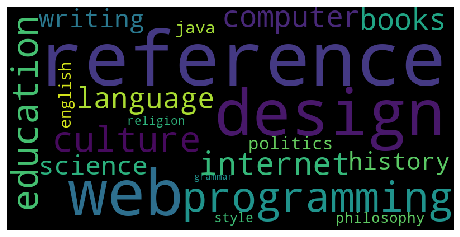

In [13]:
test = np.transpose(y_train)
cumsum = np.sum(test,axis=1)

labelsdict = {labels[i]:cumsum[i] for i in range(len(labels))}
cloud = WordCloud(width=800, height=400).generate_from_frequencies(labelsdict)
plt.figure(figsize=(8,8))
plt.imshow(cloud)
plt.axis('off')

Plot the label distribution histogram.

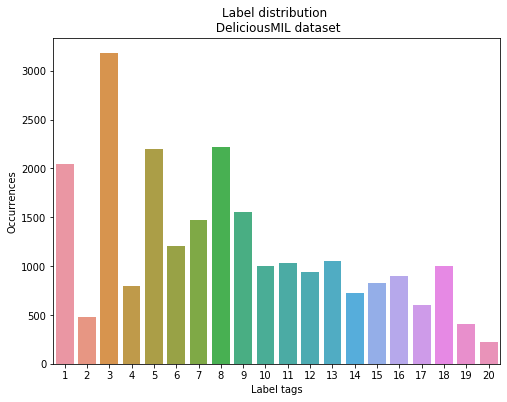

In [14]:
ind = np.arange(1, len(labels)+1)
plt.figure(figsize=(8,6))
sns.barplot(ind,cumsum)
plt.xlabel('Label tags')
plt.ylabel('Occurrences')
plt.title("Label distribution \n DeliciousMIL dataset")
plt.show()

Display distribution of tags.

In [0]:
for key,value in zip(labelsdict.keys(),labelsdict.values()):
    print('Tag : %s ,Frequency : %.f' %(key,value))

Tag : programming ,Frequency : 2050
Tag : style ,Frequency : 479
Tag : reference ,Frequency : 3181
Tag : java ,Frequency : 799
Tag : web ,Frequency : 2203
Tag : internet ,Frequency : 1211
Tag : culture ,Frequency : 1471
Tag : design ,Frequency : 2221
Tag : education ,Frequency : 1559
Tag : language ,Frequency : 1004
Tag : books ,Frequency : 1034
Tag : writing ,Frequency : 939
Tag : computer ,Frequency : 1049
Tag : english ,Frequency : 725
Tag : politics ,Frequency : 830
Tag : history ,Frequency : 898
Tag : philosophy ,Frequency : 598
Tag : science ,Frequency : 1001
Tag : religion ,Frequency : 411
Tag : grammar ,Frequency : 224


# Applying Methods

We need to pass our classifiers in a Multioutput wrapper in order to be able to make the random search.  
The multioutput strategy consists of fitting one classifier per target. This is a simple strategy for extending classifiers that do not natively support multi-target classification.

### Define Classifiers and Scoring

In [3]:
scoring = {'Hamming Loss':make_scorer(hamming_loss),'Accuracy':make_scorer(accuracy_score),
          'Micro Precision':make_scorer(micro_prec),'Micro F1':make_scorer(micro_f1)}

methods = ['CC','RAkEL','BinaryRelevance']

### Random Search for finding hyperparameters


In [5]:
for method in methods:
    pipeline(method,X_train,y_train,scoring,search_r=True,best='Micro F1')

Fitting Classifiers Chain pipeline...

Estimator: Logistic Regression
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.5min finished


Best parameters found for Estimator : Logistic Regression
{'classifier__C': 0.3054354844943646}

Best score found for Micro F1 Score metric : 0.037

Estimator: Decision Tree Classifier
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.4min finished


Best parameters found for Estimator : Decision Tree Classifier
{'classifier__criterion': 'gini', 'classifier__max_depth': 14, 'classifier__max_features': 139, 'classifier__min_samples_split': 26}

Best score found for Micro F1 Score metric : 0.153

Estimator: MultinomialNB
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.0s finished


Best parameters found for Estimator : MultinomialNB
{'classifier__alpha': 0.20008630058192634}

Best score found for Micro F1 Score metric : 0.250
Fitting RAkEL pipeline...

Estimator: Logistic Regression
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.6min finished


Best parameters found for Estimator : Logistic Regression
{'base_classifier__C': 0.6234282660646502}

Best score found for Micro F1 Score metric : 0.056

Estimator: Decision Tree Classifier
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.8min finished


Best parameters found for Estimator : Decision Tree Classifier
{'base_classifier__criterion': 'entropy', 'base_classifier__max_depth': 20, 'base_classifier__max_features': 46, 'base_classifier__min_samples_split': 19}

Best score found for Micro F1 Score metric : 0.188

Estimator: MultinomialNB
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.2s finished


Best parameters found for Estimator : MultinomialNB
{'base_classifier__alpha': 0.3310074465627679}

Best score found for Micro F1 Score metric : 0.238
Fitting BinaryRelevance pipeline...

Estimator: Logistic Regression
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished


Best parameters found for Estimator : Logistic Regression
{'classifier__C': 1.3238833072489695}

Best score found for Micro F1 Score metric : 0.035

Estimator: Decision Tree Classifier
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.6min finished


Best parameters found for Estimator : Decision Tree Classifier
{'classifier__criterion': 'gini', 'classifier__max_depth': 29, 'classifier__max_features': 75, 'classifier__min_samples_split': 47}

Best score found for Micro F1 Score metric : 0.192

Estimator: MultinomialNB
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.2s finished


Best parameters found for Estimator : MultinomialNB
{'classifier__alpha': 0.6076619213501169}

Best score found for Micro F1 Score metric : 0.250


### Grid Search for finding best hyperparameters

Define Hyperparameters for Grid search for each method and classifier respectively.

In [7]:
# Parameters for classifier chains
params_tree_cc = {'__max_depth': [14,15,16],
               '__max_features': [138,140,141,137],
               '__min_samples_split': [24,23,27,28],
               '__criterion': ['gini']}
params_lgr_cc = {'__C':[.30,1.0,0.1,2.0]}
params_nb_cc = {'__alpha': [0.22,0.18,0.24]}
params_cc = [params_lgr_cc,params_tree_cc,params_nb_cc]

#Parameters for RAkEL
params_tree_rk = {'__max_depth': [19,22,17],
               '__max_features': [45,44,48,50],
               '__min_samples_split': [18,20,22,16],
               '__criterion': ['entropy']}
params_lgr_rk = {'__C':[0.6,0.35,0.8,0.20]}
params_nb_rk = {'__alpha': [0.30,0.28,0.35]}
params_rk = [params_lgr_rk,params_tree_rk,params_nb_rk]


#Parameters for Binary Relevance
params_tree_bn = {'__max_depth': [28,30,32],
               '__max_features': [74,77,78,72],
               '__min_samples_split': [46,45,49,50],
               '__criterion': ['gini']}
params_lgr_bn = {'__C':[1.30,1.5,1.10,1.7]}
params_nb_bn = {'__alpha': [0.59,0.55,0.63]}
params_bn = [params_lgr_bn,params_tree_bn,params_nb_bn]



params_search = [params_cc,params_rk,params_bn]


In [8]:
for method,params in zip(methods,params_search):
    pipeline(method,X_train,y_train,scoring,params_search,search_r=False,best='Micro F1')

Fitting Classifiers Chain pipeline...

Estimator: Logistic Regression
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   33.6s finished


Best parameters found for Estimator : Logistic Regression
{'classifier__C': 1.0}

Best score found for Micro F1 Score metric : 0.043

Estimator: Decision Tree Classifier
Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 10.0min finished


Best parameters found for Estimator : Decision Tree Classifier
{'classifier__criterion': 'gini', 'classifier__max_depth': 16, 'classifier__max_features': 137, 'classifier__min_samples_split': 23}

Best score found for Micro F1 Score metric : 0.179

Estimator: MultinomialNB
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    2.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.0s finished


Best parameters found for Estimator : MultinomialNB
{'classifier__alpha': 0.22}

Best score found for Micro F1 Score metric : 0.250
Fitting RAkEL pipeline...

Estimator: Logistic Regression
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.2min finished


Best parameters found for Estimator : Logistic Regression
{'base_classifier__C': 0.2}

Best score found for Micro F1 Score metric : 0.069

Estimator: Decision Tree Classifier
Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  5.8min finished


Best parameters found for Estimator : Decision Tree Classifier
{'base_classifier__criterion': 'entropy', 'base_classifier__max_depth': 22, 'base_classifier__max_features': 44, 'base_classifier__min_samples_split': 16}

Best score found for Micro F1 Score metric : 0.198

Estimator: MultinomialNB
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   11.7s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   12.4s finished


Best parameters found for Estimator : MultinomialNB
{'base_classifier__alpha': 0.28}

Best score found for Micro F1 Score metric : 0.235
Fitting BinaryRelevance pipeline...

Estimator: Logistic Regression
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   21.4s finished


Best parameters found for Estimator : Logistic Regression
{'classifier__C': 1.3}

Best score found for Micro F1 Score metric : 0.042

Estimator: Decision Tree Classifier
Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 11.8min finished


Best parameters found for Estimator : Decision Tree Classifier
{'classifier__criterion': 'gini', 'classifier__max_depth': 32, 'classifier__max_features': 78, 'classifier__min_samples_split': 45}

Best score found for Micro F1 Score metric : 0.201

Estimator: MultinomialNB
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.1s finished


Best parameters found for Estimator : MultinomialNB
{'classifier__alpha': 0.59}

Best score found for Micro F1 Score metric : 0.250


### Classifier Chains

In [7]:
names = ['Logistic Regression', 'DecisionTreeClassifier', 'MultinomialNB']

Define classifiers with best hyperparameters.

In [8]:
evaluate = ['acc','hamming_loss','f1_micro','f1_macro','prec_micro','prec_macro']

In [4]:
base_lr = LogisticRegression(solver='lbfgs',C=1.0,n_jobs=-1)
base_dt = DecisionTreeClassifier(max_depth=16,max_features=137,min_samples_split=23,criterion='gini')
base_nb = MultinomialNB(alpha=0.22)
clfs = {'Logistic Regression':base_lr,'DecisionTreeClassifier':base_dt,'MultinomialNB':base_nb}

Finding independent Scores for Classifiers with OvR strategy.

In [5]:
ind_scores = {}
for clf,key in zip(clfs.values(),clfs.keys()):
    print('Fitting indepedent %s' %key)
    wrapper = OneVsRestClassifier(clf,n_jobs=-1)
    wrapper.fit(X_train,y_train)
    preds = wrapper.predict(X_test)
    
    for m in evaluate:
        ind_scores[key+ ' ' +m] = (scores(m,y_test,preds))

Fitting indepedent Logistic Regression
Fitting indepedent DecisionTreeClassifier
Fitting indepedent MultinomialNB


In [6]:
metrics_cc = CC_Fit(clfs,X_train,y_train,X_test,y_test,evaluate)

Fitting Chain Logistic Regression
Fitting Chain DecisionTreeClassifier
Fitting Chain MultinomialNB


#### Plotting Results

In [11]:
model_names = ('Indepedent','Chain 1','Chain 2','Chain 3','Chain 4','Chain 5','Chain 6',
               'Chain 7','Chain 8','Chain 9','Chain 10','Ensemble')

Maximum F1 score Classifier Chain Logistic Regression 0.0399


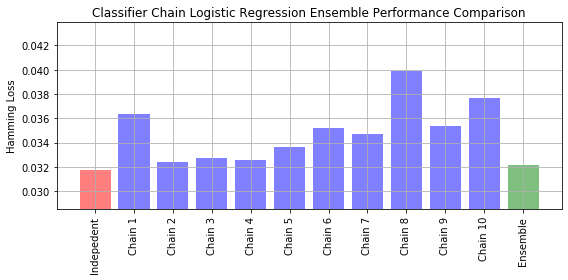

Maximum F1 score Classifier Chain DecisionTreeClassifier 0.1798


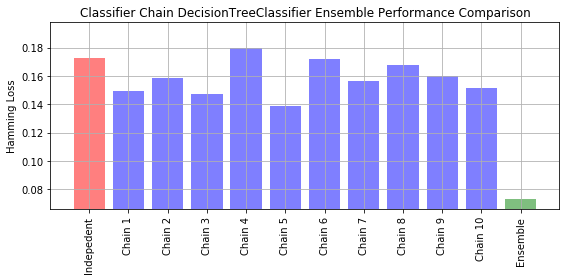

Maximum F1 score Classifier Chain MultinomialNB 0.2493


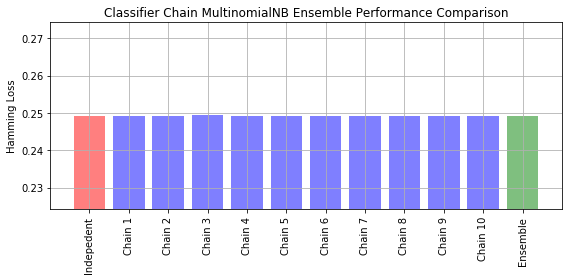

In [12]:
CC_plots(model_names,clfs,metrics_cc,ind_scores)

### RAkEL

In [13]:
base_lr = LogisticRegression(solver='lbfgs',C=0.2,n_jobs=-1)
base_dt = DecisionTreeClassifier(max_depth=22,max_features=44,min_samples_split=16,criterion='entropy')
base_nb = MultinomialNB(alpha=0.59)
clfs = {'Logistic Regression':base_lr,'DecisionTreeClassifier':base_dt,'MultinomialNB':base_nb}

In [14]:
steps = np.arange(5,12) #Define label set size
metrics_rk = RAkEL_fit(clfs,steps,X_train,y_train,X_test,y_test)

Fitting RAkEL with Base Classifier: Logistic Regression
Fitting RAkEL with Base Classifier: DecisionTreeClassifier
Fitting RAkEL with Base Classifier: MultinomialNB


#### Plotting Results

Maximum MicroF1 RAkEL DecisionTreeClassifier 0.2094
Maximum MicroF1 RAkEL Logistic Regression 0.1791
Maximum MicroF1 RAkEL MultinomialNB 0.2398


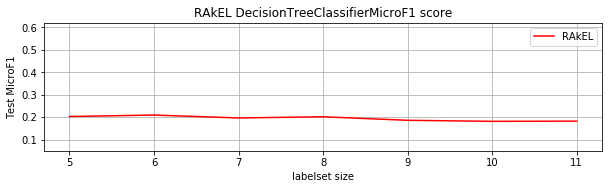

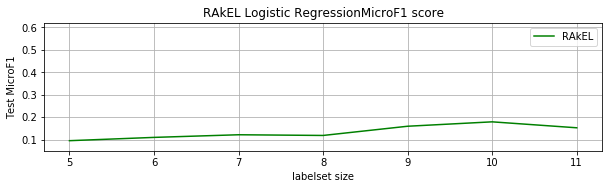

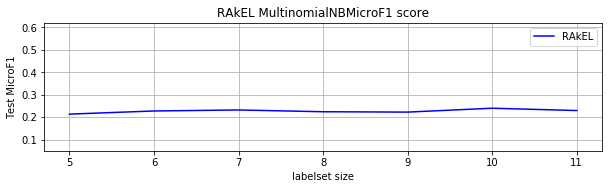

In [16]:
RAkEL_plots(steps,metrics_rk)

### Binary Relevance

In [24]:
base_lr = LogisticRegression(solver='lbfgs',C=1.3,n_jobs=-1)
base_dt = DecisionTreeClassifier(max_depth=32,max_features=78,min_samples_split=45,criterion='gini')
base_nb = MultinomialNB(alpha=0.59)
clfs = {'Logistic Regression':base_lr,'DecisionTreeClassifier':base_dt,'MultinomialNB':base_nb}

In [25]:
metrics_bn = BN_fit(clfs,X_train,y_train,X_test,y_test,evaluate)

Fitting BinaryRelevance with Classifier : Logistic Regression
Fitting BinaryRelevance with Classifier : DecisionTreeClassifier
Fitting BinaryRelevance with Classifier : MultinomialNB


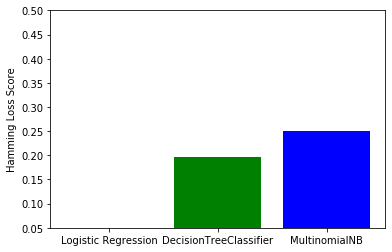

Maximum Score with Label Powersets 0.2493 MultinomialNB


In [29]:
scores = np.array([metrics_bn['Logistic Regression f1_micro'],metrics_bn['DecisionTreeClassifier f1_micro'],
         metrics_bn['MultinomialNB f1_micro']])
BN_plots(scores,names)

# Final Results and Conclusions

In this part, we present the final results of all the applied methods.

In [20]:
# We used the commented function below to produce the results and then load them.
# final_results = final_results(metrics_cc,metrics_rk,metrics_bn,evaluate,names)
# final_results.to_pickle('C:/Users/User/Desktop/final_res.pkl')
final_res = pd.read_pickle('C:/Users/User/Desktop/final_res.pkl')
final_res

,acc,f1_macro,f1_micro,hamming_loss,prec_macro,prec_micro
Logistic Regression CC,0.048958,0.013711,0.032147,0.148155,0.109570,0.319739
Logistic Regression RAkEL,0.032890,0.070883,0.095076,0.173726,0.152405,0.195851
Logistic Regression Binary Relevance,0.048958,0.012991,0.031715,0.147941,0.132784,0.327119
DecisionTreeClassifier CC,0.045192,0.040192,0.073366,0.150942,0.282826,0.341219
DecisionTreeClassifier RAkEL,0.008034,0.132656,0.202823,0.202787,0.159325,0.236669
DecisionTreeClassifier Binary Relevance,0.012051,0.131832,0.197330,0.200778,0.165101,0.235590
MultinomialNB CC,0.000000,0.228606,0.249264,0.467386,0.155932,0.162602
MultinomialNB RAkEL,0.000000,0.200573,0.213455,0.473487,0.150399,0.140709
MultinomialNB Binary Relevance,0.000000,0.228667,0.249315,0.467411,0.155965,0.162629


In [21]:
best_results(final_res)

Best acc found : 0.0490 with classifier and method :Logistic Regression CC
Best f1_macro found : 0.2287 with classifier and method :MultinomialNB Binary Relevance
Best f1_micro found : 0.2493 with classifier and method :MultinomialNB Binary Relevance
Best hamming_loss found : 0.1479 with classifier and method :Logistic Regression Binary Relevance
Best prec_macro found : 0.2828 with classifier and method :DecisionTreeClassifier CC
Best prec_micro found : 0.3412 with classifier and method :DecisionTreeClassifier CC


Evidently, the best F1 micro result was achieved with Binary relevance method and Multinomial Naive Bayes classifier.  
Acceptable results were also achieved with Binary Relevance and Logistic Regression according to the hamming loss score.  
Judging by our dataset that is a satisfiable overall result.  
On the other hand, the accuracy metric is difficult in Multilabel problems, 
because it expects from the classifier to match all the labels exactly, 
even if it predicted them all correctly except for one.  
Finally, the dataset is extremely unbalanced, which is why the micro averaging is suggested
instead for the macro averaging, because the second one does not consider the unbalanceness of the problem.